In [1]:
push!(LOAD_PATH, "../src")
include("../src/lanczos.jl")
include("../src/estimators.jl")

using .StochasticLanczos
using .Estimators
using SparseArrays
using LinearAlgebra
using FastExpm  # For computing matrix exponentials as a benchmark
using Plots
using Printf

## Validation of Functional Trace Estimation with Hutchinson Estimator
We have already shown that the block stochastic Lanczos method can accurately approximate the trace of a block functional quadratic form of $\mathbf{A}$, now it remains to put that to use in the Hutchinson estimator to show we can accurately estimate the functional trace of $\mathbf{A}$. Use test case 1, and its exact matrix funciton evaluation to compare against the stochastic Lanczos functional trace estimation as a function of block size.

In [2]:
include("test_case_1.jl");

Recall that our goal is to estimate $\mathrm{tr}(f(\mathbf{A}))$ using the stochastic Lanczos quadrature with a number of samples $s\ll n$ ($\mathbf{A}\in \mathbb{R}^{n\times n}$) using the Hutchinson estimator.

In [3]:
exact = tr(exactfA)

1.0240734232325006e46 + 0.0im

In [4]:
s = 10
b = 2
k = 10
hutchinson_estimator(f, matvecA, n, s, b, k)

1.0472736762990153e46

## Validation of Estimator Statistics
This gives an okay estimate, but of course it is inherently random, and we have some nonzero variance about the true functional trace value. Recall that for a Rademacher distribution, the variance of the Hutchinson estimator is given by
$$
\frac{1}{s}\mathrm{Var}[X] = \frac{1}{s}2\sum_{i\neq j}\lvert \tilde{a}_{ij} \rvert^2<\frac{1}{s}2 \lVert f(\mathbf{A}) \rVert _F^2
$$
we can check this expression for the variance by explicitly computing the sample variance by taking a sufficient number of samples of our stochastic trace estimator, and estimating the variance via
$$
\hat{\sigma}_{\mathrm{tr-estimator}}^2 = \frac{1}{N-1}\sum_{i=1}^N (x_i - \overline{x})^2
$$
where $N$ is the number of samples, and $\overline{x}$ is the sample mean. First, we compute the quantity $\sum_{i\neq j}\lvert \tilde{a}_{ij} \rvert^2$ which is the off-diagonal (square) frobenius norm of $f(\mathbf{A})$ 

In [5]:
# Extract the row indices, column indices, and values of non-zero elements
rows, cols, values = findnz(SparseMatrixCSC(exactfA))
    
# Compute the sum of squared magnitudes of off-diagonal elements
offDiagFrobeniusA = sum(v^2 for (i, j, v) in zip(rows, cols, values) if i != j)

2.490038382244126e91 + 0.0im

In [6]:
s = 10
b = 2
k = 10
exact_variance = 1/s*2*offDiagFrobeniusA

4.980076764488253e90 + 0.0im

In [7]:
μ, variance = estimator_statistics(hutchinson_estimator, f, matvecA, n, s, b, k; num_samples=50)

# Compare estimated Hutchinson estimator mean and variance to theoretical values
percent_diff_variance = Real(abs(exact_variance - variance)/exact_variance*100)
percent_diff_mean = Real(abs(μ - exact)/exact*100)
println("Percent difference between estimated and theoretical variance: $(@sprintf("%.2f", percent_diff_variance))%")
println("Percent difference between estimated and theoretical mean: $(@sprintf("%.2f", percent_diff_mean))%")

# Now compute the percent uncertainty in the functional trace estimate
σ = sqrt(variance)
percent_uncertainty_trace_estimate = σ/μ*100
println("Percent uncertainty in functional trace estimate: $(@sprintf("%.2f", percent_uncertainty_trace_estimate))%")


Percent difference between estimated and theoretical variance: 14.90%
Percent difference between estimated and theoretical mean: 2.25%
Percent uncertainty in functional trace estimate: 20.56%


We see that there is a reasonably small uncertainty in the functional trace estimation despite a small number of samples $s$ relative to the dimensions of the matrix $\mathbf{A}$ (i.e. $n$), and for the most part the estimated variance and mean of the Hutchinson estimator agree with the theoretical results.

## Estimator Convergence Rate as a Function of Block Size
Now it's worth considering the accuracy of the stochastic Lanczos method as a function of the block size. We perform this comparison by keeping the computational complexity the same beteween runs and comparing the accuracy. The computational complexity is measured in the number of single-vector Lanczos iteration steps used in the entire Hutchinson trace estimation. I.e. if $k$ steps of _block_ stochastic Lanczos are used with a block size of $b$ and  $s$ samples, the number of single vector Lanczos steps is $kb\frac{s}{b}= ks$, which is notably independent of the block size. So for a fair comparison, we just keep the number of Lanczos steps consistent across different block sizes. 

Now, we wish to measure the convergence rate of block Lanczos method to the Hutchinson estimator for a fixed sample size $s$ (we know how the Hutchinson estimator converges to the true functional trace as a function of the sample size, i.e. the standard deviation decreases like $\frac{1}{\sqrt{s}}$ as is typical for stochastic estimators) as we vary the number of Lanczos steps $k$ for various block sizes $b$.

First we compute a reference "exact" computation of the Hutch estimator for a given sample size, which is given by that with k sufficiently large.

In [8]:
s = 40
b = 2
k_converged = 100
Ω_provided = [rand([-1, 1]) for _ in 1:n, _ in 1:s];
converged_estimate = hutchinson_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided)

1.1146613736170983e46

In [9]:
ks = collect(1:1:10)

using Base.Threads
function compute_block_estimates(ks, bs, s)
    block_estimates = zeros(length(bs), length(ks))

    # Now, compute all of the estimates
    Threads.@threads for idx in CartesianIndices(block_estimates)
        b_index, k_index = Tuple(idx)
        b = bs[b_index]
        k = ks[k_index]
        block_estimates[b_index, k_index] = hutchinson_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided)
    end

    return block_estimates
end

bs = divisors(s)
block_estimates = compute_block_estimates(ks, bs, s);

Now plot the results

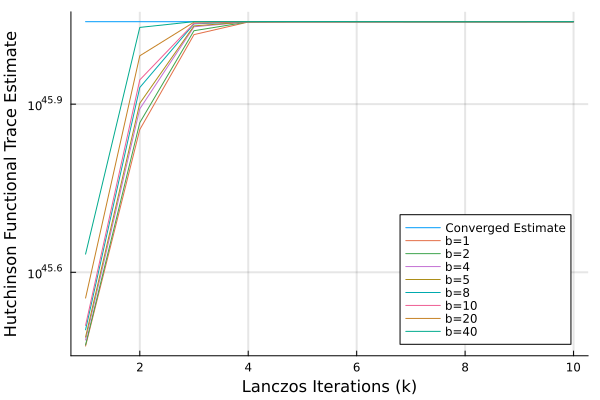

In [10]:
function plot_block_estimates(block_estimates, ks, bs, converged_estimate; k_max=ks[end], logscale=true)
    max_k_index = findfirst(>=(k_max), ks)

    plot_scale = logscale ? :log10 : :ln
    p = plot(ks[1:max_k_index], fill(converged_estimate, length(ks))[1:max_k_index], label="Converged Estimate")
    for (b_index, b) in enumerate(bs)
        plot!(p, ks[1:max_k_index], block_estimates[b_index, 1:max_k_index], label="b=$b", xlabel="Lanczos Iterations (k)", 
        ylabel="Hutchinson Functional Trace Estimate", gridlinewidth=2, yscale=plot_scale)
    end

    return p
end

p = plot_block_estimates(block_estimates, ks, bs, converged_estimate)
display(p)

In [11]:
savefig("block_convergence_case_1_s$(s).png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/block_convergence_case_1_s40.png"

## A Higher Condition Number Test Case
For this random matrix, the block stochastic Lanczos algorithm converges relatively quickly, so we devised a test case with a much higher condition number that is expected to converge much more slowly

In [12]:
include("test_case_2.jl")
exact = tr(exactfA)

160916.43436339582

In [13]:
s = 40
b = 20
k_converged = 50
Ω_provided = [rand([-1, 1]) for _ in 1:n, _ in 1:s];
converged_estimate = hutchinson_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided)

160110.6072545961

Note that, apparently the Lanczos iteration is unstable for large block sizes, so we have excluded the largest possible block size ($b=s$).

In [14]:
ks = collect(1:1:20)
bs = divisors(s)[1:end-1]
block_estimates = compute_block_estimates(ks, bs, s);

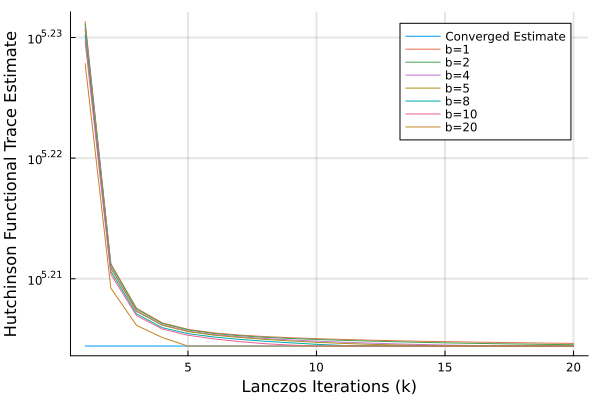

In [15]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate, logscale=true)
display(p)

In [16]:
savefig("block_convergence_case_2_s$(s).png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/block_convergence_case_2_s40.png"

Note the above shows that larger block sizes tend to converge more quickly than smaller block sizes, however, the current implementation of the Lanczos algorithm (that employs no reorthogonalization) isn't stable for very large block sizes, and that fact can easily be seen in the above plot by looking at the curve for $b=40$.

## Comparing the Effect of Blocking on the Estimator Variance
The blocking formally leads to a loss of exchangability (though I would expect this is numerically negligible, since we're estimating the same quantity in either case, and if we're doing a good job at it, it shouldn't depend on how we choose to group the vectors into blocks). Now, the exchangability principle states that the optimal estimator (with minimal variance) is exchangable, so blocking could potentially increase the variance of the estimator. To verify that it does not, we can compute the sample variance of the blocked and unblocked estimators for various block sizes.

First, we need to determine how many samples to use to get an accurate estimation of the estimator variance. Note that the sample variance is defined as
$$
S^2 = \frac{1}{N-1}\sum_{i=1}^N (x_i - \overline{x})^2
$$
and the variance of the sampling distribution of the sample variance ($S^2$) is given by
$$
\mathrm{Var}(S^2) = \frac{2\sigma^4}{N-1} 
$$
where $\sigma$ is the "population" standard deviation, i.e. the true standard deviation of the Hutchinson estimator, which is given by
$$
\sigma^2 = \frac{1}{s}2\sum_{i\neq j}\lvert \tilde{a}_{ij} \rvert^2
$$
where $s$ is the number of samples. To cut down on computation, we could choose an example whose functional trace $\tilde{\mathbf{A}}\equiv f(\mathbf{A})$ has a small $\sum_{i\neq j}\lvert \tilde{a}_{ij} \rvert^2$ so that we don't need too many samples $N$ to get a good estimate of the estimator variance $\sigma^2$. To do this, we use the same test case with $f(x)=x^{1/3}$, but with a matrix $\mathbf{A}$ with a smaller condition number. We can also estimate the variance of the sample variance using the sample variance itself, i.e.
$$
\hat{\mathrm{Var}}(S^2) = \frac{2S^4}{N-1} 
$$

In [17]:
include("test_case_3.jl");

In [18]:
# Extract the row indices, column indices, and values of non-zero elements
rows, cols, values = findnz(SparseMatrixCSC(exactfA))
    
# Compute the sum of squared magnitudes of off-diagonal elements
offDiagFrobeniusA = sum(v^2 for (i, j, v) in zip(rows, cols, values) if i != j)
σsq = 2/s*offDiagFrobeniusA

2.8709225729620633

In [19]:
s = 40
b = 2
k = 10 # Choose large enough so that estimate is converged regardless of block size
N = 10000
variance_of_sample_variance = 2*σsq^2/(N-1)
stddev_of_sample_variance = sqrt(variance_of_sample_variance) # We can only be sure that this is only true for the unblocked case

0.040603006593146064

In [20]:
using Base.Threads

bs = divisors(s)[1:end] # Exclude b=s for stability concerns again
variance_estimates = zeros(length(bs))
error_of_variance_estimates = zeros(length(bs))
Threads.@threads for b_index in eachindex(bs)
    b = bs[b_index]
    _, variance_estimate = estimator_statistics(hutchinson_estimator, f, matvecA, n, s, b, k; num_samples=N)
    variance_estimates[b_index] = variance_estimate
    error_of_variance_estimates[b_index] = sqrt(2 * variance_estimate^2 / (N - 1))
end


Note, in the plot below, we compare the computed estimator varianec with the theoretically computed _exact_ variance of the Hutch estimator (at least for a block size $b=1$) and see if there are any discrepancies, e.g. for $b\neq 1$.

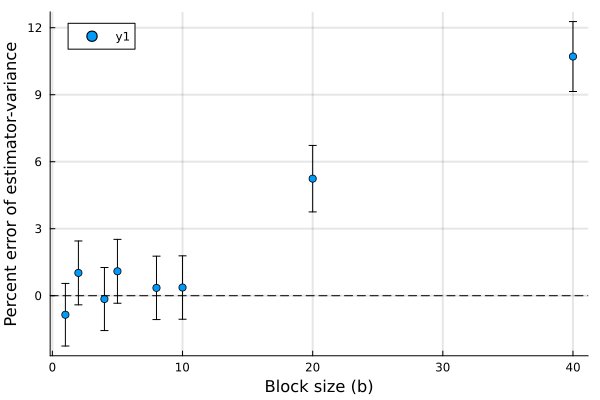

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/project/test/variance_block_dependence.png"

In [21]:
# Now plot the results
p = scatter(bs, (variance_estimates .- σsq)/σsq*100, yerr=error_of_variance_estimates./σsq*100, xlabel="Block size (b)", ylabel="Percent error of estimator-variance", 
        gridlinewidth=2)
hline!([0], linestyle=:dash, color=:black, label="")
display(p)
savefig("variance_block_dependence.png")

In [22]:
k_converged = 20
ks = collect(1:1:20)
bs = divisors(s)[1:end-1]
converged_estimate = hutchinson_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided)
block_estimates = compute_block_estimates(ks, bs, s);

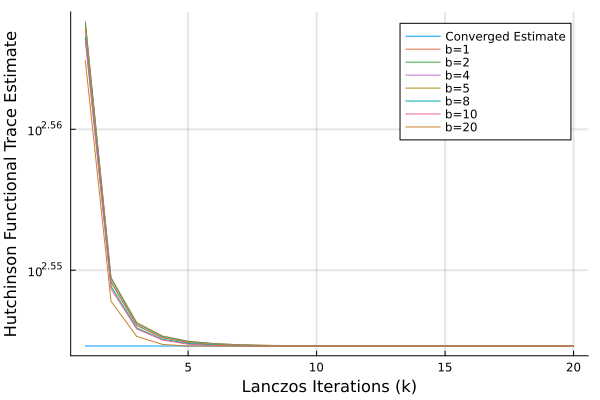

In [23]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate, logscale=true)
display(p)

The above choice shows that $k=10$ is sufficient for all block sizes to converge, so the results for the variance are consistent.